_**This notebook is associated with [this tweet](https://twitter.com/aaronmcdaid/status/1345744752046649349)**_

Contact me on [Twitter `@aaronmcdaid`](https://twitter.com/aaronmcdaid) with any comments or questions!

# .

Bayesians doing A/B testing,
When getting priors from your domain expert, don't waste their time on questions that don't affect the posterior 𝑜𝑓 𝑖𝑛𝑡𝑒𝑟𝑒𝑠𝑡.

I have a simple question here, but I first need to set up my example:

n₁ people saw Version 1 of the ad, and c₁ people clicked on it. n₂ and c₂ are for Version 2

The priors for the true click through rates (CTR) are θ₁ ~ 𝐵𝑒𝑡𝑎(𝑎₁,𝑏₁) and θ₂ ~ 𝐵𝑒𝑡𝑎(𝑎₂,𝑏₂)

Therefore the exact posteriors are θ₁|· ~ Beta(a₁+c₁, b₁+n₁-c₁) and θ₂|· ~ Beta(a₂+c₂, b₂+n₂-c₂)

In the end, we don't care so much about the two posterior rates. Instead, we just want the posterior of their difference, Δ=θ₂-θ₁, as this will be used to decide which Version is better.

Any univariate posterior will be Normally distributed - assuming a reasonable sample size - therefore we just need its mean and variance.

This notebook computes an approximation of the mean and variance in the posterior by combining the mean and variance of the prior and of the likelihood by pretending the prior and likelihood are normal

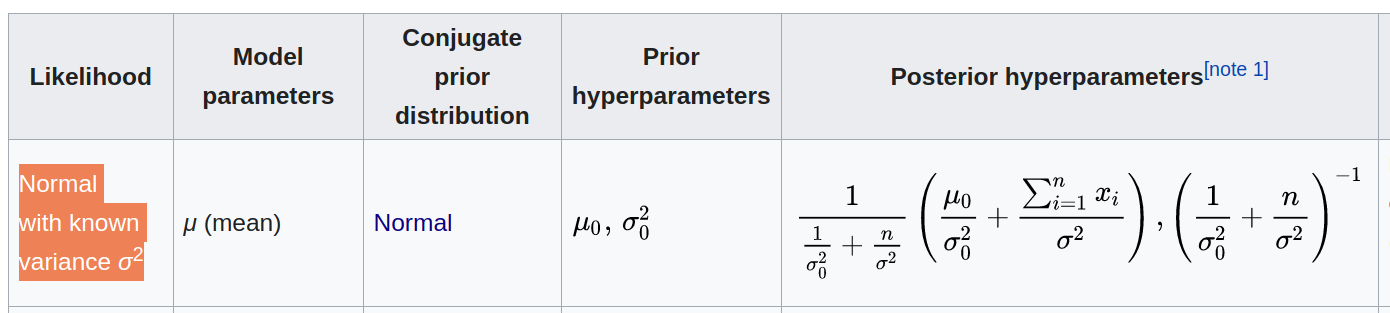

The approximations are compared to the mean and variance of the difference of the two exact posteriors. The appromixations are very good.

This shows that we don't need to ask the domain expert for all the prior parameters (𝑎₁,𝑏₁,𝑎₂,𝑏₂), which can be difficult to explain. Just ask for two easily-explained numbers, E[θ₂-θ₁] and Var[θ₂-θ₁], as these are sufficient to compute the posterior of interest

Does this generalize further? With large samples, can we generally approximate the prior and likelihood using (multivariate) normals? https://stats.stackexchange.com/questions/263640/when-does-asymptotic-normality-of-the-bayesian-posterior-bernstein-von-mises-f




In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import beta, binom

In [2]:
def simulate(a_1, b_1, n_1, a_2, b_2, n_2):
    
    """
    This is quite a long function, it has four main steps:
     1. Draw a 'true' rate from each of the two priors.
     2. For each of the two groups, draw the number of clicks and non-clicks.
     3. Compute the exact posterior: the mean and variance are
        from the difference of two Beta distributions.
     4. Compute the approximate posterior by:
          - computing the mean and variance of the prior,
          - and computing the difference of the means in the sample (and the variance of that estimator)
          - and combining these via a weighted average
    """
    
    # Draw the 'true' rates from the priors
    prior_1 = beta(a_1, b_1)
    prior_2 = beta(a_2, b_2)
    θ_1 = prior_1.rvs()
    θ_2 = prior_2.rvs()
    
    # Draw the number of clicks, 'c', and non-clicks 'd'.
    c_1 = binom(n=n_1, p=θ_1).rvs()
    c_2 = binom(n=n_2, p=θ_2).rvs()
    d_1 = n_1 - c_1
    d_2 = n_2 - c_2
    
    # Compute the exact posterior. Remember, we don't really care about
    # the individual Beta distributions, just their difference:
    post_1 = beta(a_1 + c_1, b_1 + d_1)
    post_2 = beta(a_2 + c_2, b_2 + d_2)
    post_variance = post_1.var() + post_2.var()
    post_mean = post_2.mean() - post_1.mean()
    
    # We'll now approximate the posterior as if everything in this model was normally distributed.
    # This means combining the means and variances following the first entry in this table:
    # "Normal with known variance σ2":
    #   https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution
    
    # Estimate the variance as the sum of the precisions. This
    # requires first computing the variance in the prior
    prior_variance = prior_1.var() + prior_2.var()
    
    # Compute the variance in the likelihood, similar to just running a t-test:
    sample_variance_1 = (c_1/n_1) * (d_1/n_1)
    sample_variance_2 = (c_2/n_2) * (d_2/n_2)
    variance_of_estimator_of_difference = sample_variance_1 / n_1 + sample_variance_2 / n_2
    
    # Now we have our estimate of the variance in the posterior
    approx_posterior_variance = 1/(1/prior_variance + 1/variance_of_estimator_of_difference)
    
    # The mean of the posterior is approximated as the weighted sum of two means:
    #  The prior mean difference:
    prior_mean_diff = prior_2.mean() - prior_1.mean()
    #  The likelihood difference:
    likelihood_mean_diff = c_2/n_2 - c_1/n_1
    # Weighted combination of those two, weighted according the the precision
    approx_posterior_mean = (
        prior_mean_diff/prior_variance + likelihood_mean_diff/variance_of_estimator_of_difference
    ) / (
                      1/prior_variance +                    1/variance_of_estimator_of_difference
    )
    
    
    return pd.DataFrame(dict(
        post_variance = post_variance,
        approx_posterior_variance = approx_posterior_variance,
        post_mean = post_mean,
        approx_posterior_mean = approx_posterior_mean,
    ), index=[0])
  

In [3]:
# Do 1000 simulations and store them in a dataframe
M = 100
a, b = 3, 800
c, d = 5, 60
df = pd.concat([simulate(a, b, 10000, c, d, 10000) for _ in range(M)])
df.head()

,post_variance,approx_posterior_variance,post_mean,approx_posterior_mean
0,0.000007,0.000007,0.072084,0.072107
0,0.000007,0.000007,0.069584,0.069722
0,0.000009,0.000009,0.091217,0.091046
0,0.000005,0.000005,0.037717,0.037550
0,0.000006,0.000006,0.061611,0.061667


In [4]:
def scatter_with_equality_line(xs, ys):
    mn = min(xs.min(), ys.min())
    mx = min(xs.max(), ys.max())
    plt.scatter(xs, ys)
    plt.plot([mn, mx], [mn, mx], color='grey')

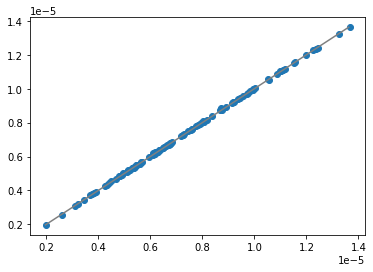

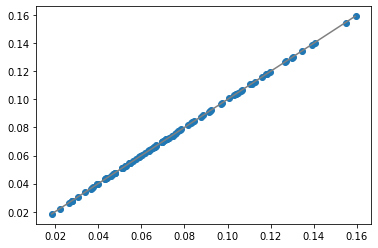

In [5]:
scatter_with_equality_line(df.post_variance, df.approx_posterior_variance)
plt.figure()
scatter_with_equality_line(df.post_mean, df.approx_posterior_mean);

This breaks down a bit with extreme parameter values. But in general, as long as the two priors are similar to each other (which is what you have in real-world application) and the sample size is reasonably large,

,post_variance,approx_posterior_variance,post_mean,approx_posterior_mean
0,0.000001,0.000001,0.011366,0.011378
0,0.000001,0.000001,0.012012,0.012047
0,0.000001,0.000001,0.007681,0.007604
0,0.000001,0.000001,0.012853,0.012913
0,0.000002,0.000002,0.017570,0.017525


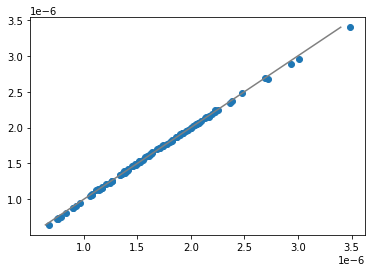

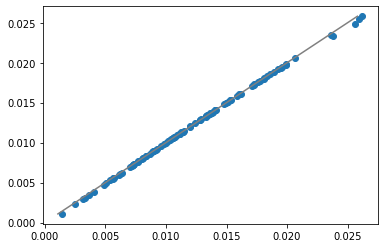

In [6]:
# Do 1000 simulations and store them in a dataframe
M = 100
a, b = 2, 800
c, d = 8, 500
df = pd.concat([simulate(a, b, 10000, c, d, 10000) for _ in range(M)])
display(df.head())

scatter_with_equality_line(df.post_variance, df.approx_posterior_variance)
plt.figure()
scatter_with_equality_line(df.post_mean, df.approx_posterior_mean);